In [1]:
import os 

SETUP = {
    'CURR_DIR': os.getcwd(),
    'PASSING_SCORE': 13,
    'DEBUG': False,
    'DEBUG_EPISODES': 500,
    'EPISODES': 2000,
    'MAX_STEPS': 1000,
    'EPS_INI': 1.0, 
    'EPS_END': 1e-5,
    'EPS_DECAY': 0.995,
    'GAMMA': 0.98,
    'SEED':32,  
    'BUFFER_SIZE': int(1e5),
    'BATCH_SIZE': 64,
    'GAMMA': 0.99,
    'TAU': 2e-3,
    'LR': 4e-4,
    'UPDATE_EVERY': 3,
    'FC1_UNITS': 64,
    'FC2_UNITS': 64,
    'USE_DOUBLE_DQN': False,
    'USE_DUELING_DQN': False,
    'USE_PRIORITIZED_EXP_REP':False,
}

try:
  import google.colab
  SETUP['IN_COLAB'] = True
except: SETUP['IN_COLAB'] = False

SUBVERSION = "v1.0.0"
SPECIFIC_RUN = 'SimpleCNN'
VERSION_KEY = 'BananaNavigation'

SETUP['RUN-KEY'] = "_".join([SUBVERSION, SPECIFIC_RUN, VERSION_KEY]) + '_'

In [2]:
from pathlib import Path

if SETUP['IN_COLAB']:
    from google.colab import drive
    drive.mount('/content/gdrive')
    SETUP['PATH'] = Path("/content/gdrive/MyDrive/_Colab/RL-SmartAgent-BananaGame")
    !pip install optuna --quiet
    !cd '/content/gdrive/MyDrive/_Colab/RL-SmartAgent-BananaGame/python'; pip install .
else: SETUP['PATH'] = Path(".")

SETUP['BANANA_PATH'] = str(SETUP['PATH'] / 'Banana_Linux_NoVis/Banana.x86_64') if SETUP['IN_COLAB'] else str(SETUP['PATH'] / "Banana.app")
os.chdir(SETUP['PATH'])

if SETUP['DEBUG']: SETUP['EPISODES'] = SETUP['DEBUG_EPISODES']

# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

## Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
env = UnityEnvironment(file_name="VisualBanana.app")

Mono path[0] = '/Users/joao/Cloud/GDrive/_Colab/RL-SmartAgent-BananaGame/VisualBanana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/joao/Cloud/GDrive/_Colab/RL-SmartAgent-BananaGame/VisualBanana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Number of agents: 1
Number of actions: 4
States look like:
States have shape: (1, 84, 84, 3)
(3, 84, 84)
(1, 3, 84, 84)


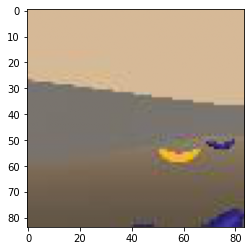

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
print('States have shape:', state.shape)
print(np.squeeze(state).transpose((2, 0, 1)).shape)
print(state.transpose((0, 3, 1, 2)).shape)
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [7]:
def randomStes():
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.visual_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.visual_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    print("Score: {}".format(score))
    env.close()

When finished, you can close the environment.

##  It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
state_size

(1, 84, 84, 3)

In [9]:
from agent_vision import Agent_vision
import datetime
from collections import deque
import torch
import time
    
def dqn(agent_params, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, verbose=True, returnFullscores=True, stopTrainingAfterGoal=True):
    agent = Agent_vision(**agent_params)
    
    n_starting = 1
    
#    agent.qnetwork_local.load_state_dict(torch.load(f'./models/checkpoint_local_pixels{n_starting}.pt'))
#    agent.qnetwork_local.load_state_dict(torch.load(f'./models/checkpoint_target_pixels{n_starting}.pt'))
    passing_score = SETUP['PASSING_SCORE']

    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        verbose (bool): print progress or not 
        returnFullscores (bool): whether to return full scores or only the episode where game was solved
        stopTrainingAfterGoal (bool): whether to continue training after achieving goal to check full potential
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    announcedWin = False
    for i_episode in range(n_starting, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        #state = env.reset()
        state = env_info.visual_observations[0]
        state = state.squeeze(0).transpose(2,0,1)
        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            
            next_state = env_info.visual_observations[0]  # get the next state
            next_state = next_state.squeeze(0).transpose(2,0,1)
            
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        if verbose: print(f'\r{str(datetime.datetime.now()):<30}Episode {str(i_episode):<5}\tAverage Score: {np.mean(scores_window):<4.2f}', end="")
        if i_episode % 100 == 0 and verbose: 
            print()
            
            state = 0
            next_state = 0
            torch.save(agent.qnetwork_local.state_dict(), f'models/checkpoint_local_pixels{i_episode}.pt')
            torch.save(agent.qnetwork_target.state_dict(), f'models/checkpoint_target_pixels{i_episode}.pt')
            np.save(f'saved_score/checkpoint_local_pixels{i_episode}.npy', scores)
        if np.mean(scores_window) >= passing_score and not announcedWin:
            if verbose: print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            if not SETUP['DEBUG']: 
                torch.save(agent.qnetwork_local.state_dict(), 'models/checkpoint_local.pt')
                torch.save(agent.qnetwork_target.state_dict(), 'models/checkpoint_target.pt')
            if stopTrainingAfterGoal: break
            else: announcedWin=True
        
    
    # for hyperparameter search, it's helpfull to return only the first time 
    if returnFullscores: return scores
    else: return i_episode + (np.where(np.array(scores) > passing_score)[0][0] if len(np.where(np.array(scores) > passing_score)[0]) > 0 else 999999)

In [10]:
%load_ext autoreload
%autoreload 2

agent_params = {'state_size': state_size, 'action_size':action_size, 'seed':SETUP['SEED'],
                'BUFFER_SIZE': SETUP['BUFFER_SIZE'], 'BATCH_SIZE': SETUP['BATCH_SIZE'], 
                'GAMMA': SETUP['GAMMA'], 'TAU': SETUP['TAU'], 'LR': SETUP['LR'],
                'UPDATE_EVERY': SETUP['UPDATE_EVERY'],'fc1_units': SETUP['FC1_UNITS'],
                'fc2_units': SETUP['FC2_UNITS']}

In [11]:
%load_ext autoreload
%autoreload 2

import torchsummary
from agent_vision import Agent_vision

agent = Agent_vision(**agent_params)
torchsummary.summary(agent.qnetwork_local, (3, 84, 84))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 84, 84]             256
              ReLU-2           [-1, 64, 84, 84]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5            [-1, 256, 9, 9]         295,168
              ReLU-6            [-1, 256, 9, 9]               0
            Conv2d-7            [-1, 512, 3, 3]       1,180,160
              ReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9           [-1, 1024, 1, 1]       4,719,616
             ReLU-10           [-1, 1024, 1, 1]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
             Re

In [13]:
scores_per = dqn(agent_params, SETUP['EPISODES'], SETUP['MAX_STEPS'], SETUP['EPS_INI'],
                 SETUP['EPS_END'], SETUP['EPS_DECAY'], verbose=True, stopTrainingAfterGoal=False)
print('Episode 100	Average Score: 0.20')
print('Episode 200	Average Score: 0.16')
print('Episode 300	Average Score: 0.70')
print('Episode 427	Average Score: 0.70')

Episode 100	Average Score: 0.20
Episode 200	Average Score: 0.16
Episode 300	Average Score: 0.70
Episode 427	Average Score: 0.70
